## **Pairs Trading using Log Price Ratio**

**Rationale**
1. There seems to be a correlation between some of the stocks in NASDAQ and QQQ from analyzing stock prices over the past few years.
- This implies that there is a long-term relationship between the two stock prices, suggesting that they move together, making them suitable for pairs trading.

**Advantages of Log Spread over Normal Spread**
- Stabilization of Variance indicates that the spread's fluctuation is less sensitive to the absolute price level of the assets. Thus, providing a more consistent measure of the relationship between the 2 assets instead.
- Captures relative differences more effectively as it reflects multiplicative relationships rather than additive relationships.

NOTE: This Notebook is strictly for educational purposes only.

**Gather Historical Data for all the stocks
 of interest**
 - We will use Yahoo Finance to extract potential stocks and their data.

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure
from datetime import datetime
from statsmodels.tsa.stattools import coint

def get_historical_data(tickers):
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        stock_data = yf.download(
            i,
            start=datetime(2024, 1, 1),
            end=datetime(2024, 10, 1),
            interval='1h',
            prepost=True
        ).iloc[:, 4]  # 'Adj Close' column (index 4)

        data = pd.concat([data, pd.DataFrame(stock_data)], axis=1)
        names.append(i)

    data.columns = names
    return data

tickers = ["QQQ", "NVDA", "AMZN", "GOOG", "AAPL", "TSLA", "META", "AVGO", "MSFT", "NFLX", "COST", "TQQQ"]
df = get_historical_data(tickers)
df.tail(10)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,QQQ,NVDA,AMZN,GOOG,AAPL,TSLA,META,AVGO,MSFT,NFLX,COST,TQQQ
Datetime,,,,,,,,,,,,
2024-09-30 10:30:00-04:00,486.890015,120.973801,185.530807,165.475006,231.899994,259.489990,573.349976,172.845001,427.921997,706.839905,891.650024,71.959900
2024-09-30 11:30:00-04:00,487.149994,120.714996,186.119995,165.990005,232.119995,260.718201,573.679993,172.089996,428.649902,707.000000,889.929993,72.065002
2024-09-30 12:30:00-04:00,485.720001,120.100700,185.619995,165.630005,231.645004,258.519989,570.594971,171.190002,427.459991,707.150513,887.000000,71.440002
2024-09-30 13:30:00-04:00,483.785004,119.470001,185.350006,165.360001,231.009995,256.869904,567.690002,170.240005,425.920013,703.820007,884.127625,70.570099
2024-09-30 14:30:00-04:00,485.199188,120.084999,185.550003,166.070007,231.220001,258.720001,569.400024,171.070007,427.204987,707.200012,884.885010,71.209999
2024-09-30 15:30:00-04:00,488.049988,121.489998,186.309998,167.179993,233.000000,261.605011,572.359985,172.460007,430.339996,709.270020,886.468994,72.470001
2024-09-30 16:00:00-04:00,487.150000,121.200000,185.360000,166.690000,232.860000,261.050000,572.050000,172.210000,428.160000,709.435000,886.310000,72.090000
2024-09-30 17:00:00-04:00,487.400000,121.060000,185.525000,166.757500,232.880000,261.070000,572.030000,172.145000,428.440000,708.685000,886.540000,72.175000
2024-09-30 18:00:00-04:00,487.180000,121.080000,185.640000,166.865000,232.800000,261.225500,572.330000,172.070000,428.335000,708.605000,886.495000,72.090000


**Test for Cointegration between the gathered stocks**

- Cointegration tests whether the 2 securities will revert around a mean over a long-period of time.
- If the difference (spread) between the 2 securities is able to form some linear combination: S2 = $\alpha$ + $\beta$ * S1 + $\epsilon$, then they are considered to be conintegrated.

In [2]:
def find_cointegrated_pairs(df, tickers, threshold = 0.05):
  coint_matrix = pd.DataFrame(index=tickers, columns=tickers)
  pairs = []
  for i in range(len(tickers)):
      for j in range(len(tickers)):
          if i != j:
              stock1_data = df[tickers[i]].dropna()
              stock2_data = df[tickers[j]].dropna()

              # Align the data based on their indices
              aligned_data = pd.concat([stock1_data, stock2_data], axis=1, join='inner')
              aligned_data.columns = [tickers[i], tickers[j]]

              # Check if there's enough data after aligning
              if len(aligned_data) > 1:
                  score, p_value, _ = coint(aligned_data[tickers[i]], aligned_data[tickers[j]])
                  coint_matrix.iloc[i, j] = p_value  # Store the p-value in the matrix
                  if p_value < threshold:
                      pairs.append((tickers[i], tickers[j]))
              else:
                  coint_matrix.iloc[i, j] = np.nan  # Not enough data for cointegration test
          else:
              coint_matrix.iloc[i, j] = np.nan  # Diagonal elements are NaN

  return coint_matrix, pairs

Pairs:[('QQQ', 'AVGO'), ('META', 'NFLX'), ('AVGO', 'QQQ'), ('AVGO', 'NFLX'), ('AVGO', 'COST'), ('NFLX', 'AVGO'), ('COST', 'AVGO')]


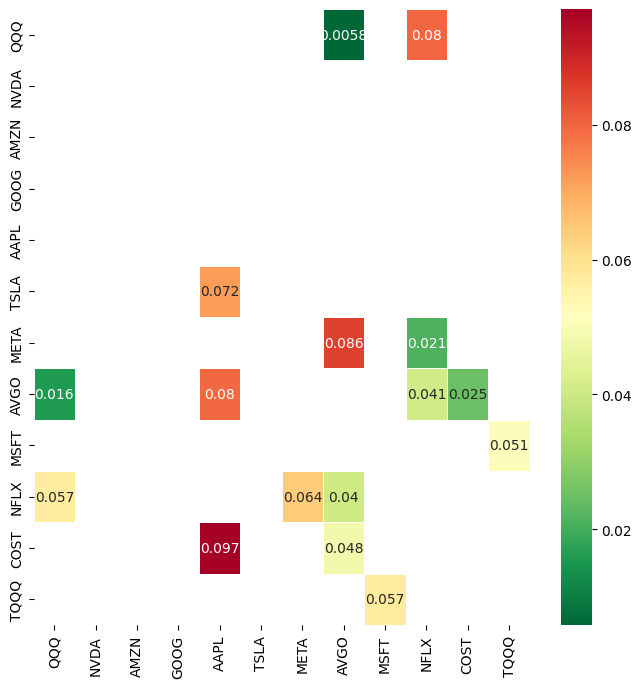

In [3]:
coint_matrix, pairs = find_cointegrated_pairs(df, tickers)

print(f"Pairs:{pairs}")

coint_long = coint_matrix.reset_index().melt(id_vars='index', var_name='Stock2', value_name='P-Value')
coint_long.rename(columns={'index': 'Stock1'}, inplace=True)

# Remove any rows with NaN P-values (like diagonal elements or where there's insufficient data)
coint_long.dropna(subset=['P-Value'], inplace=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 8))
heatmap_data = coint_matrix.astype(float)  # Ensure values are float for proper heatmap scaling

# Generate the heatmap
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', cbar=True, linewidths=0.5, mask = (heatmap_data >= 0.1))


# Show the plot
plt.show()

**Test for Correlation between all the gathered stocks**

<Axes: >

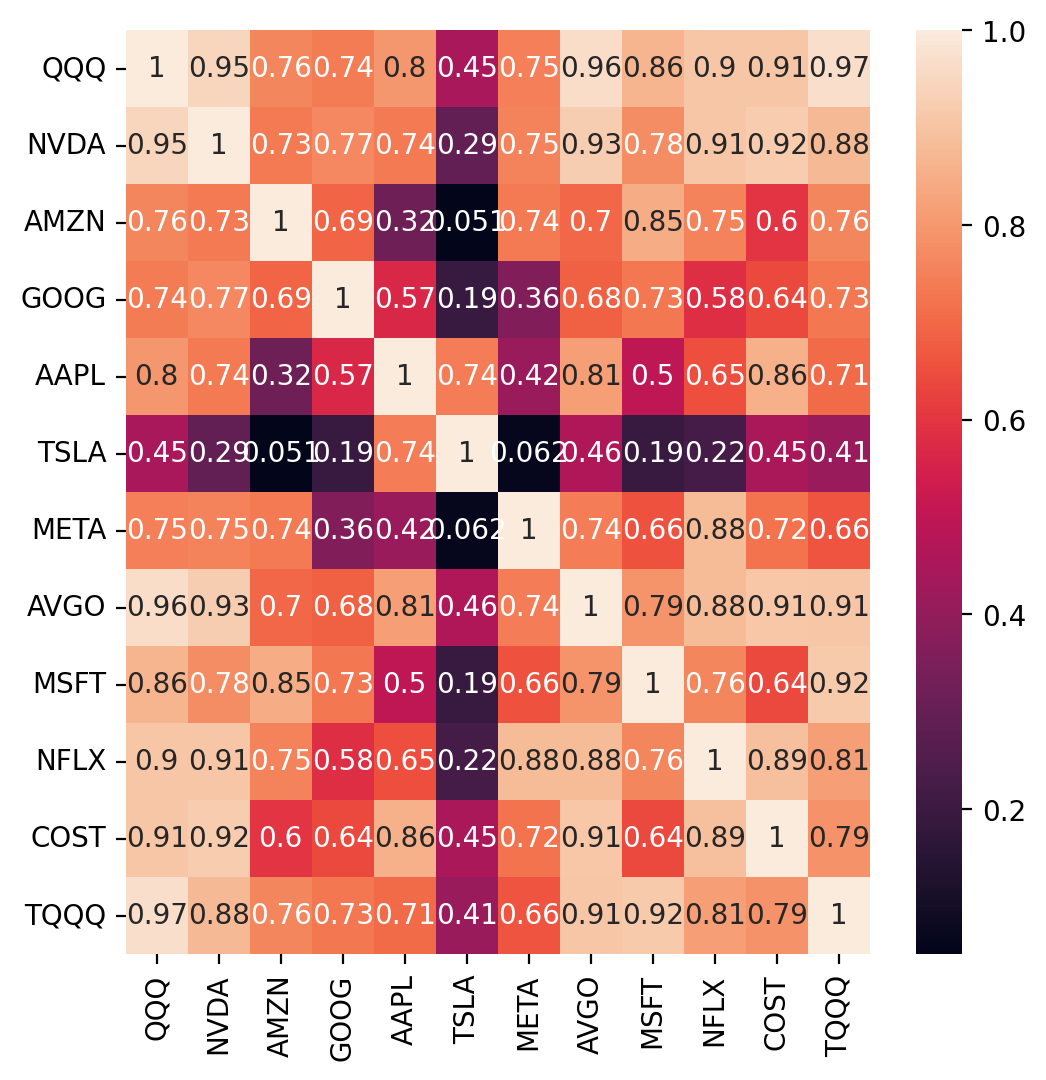

In [4]:
corr_matrix = df.corr()

figure(figsize=(6, 6), dpi=200)
sns.heatmap(corr_matrix, annot = True)

**Calculate Log Spread between the 2 Stocks**
- In particular, calculate the spread between AVGO and QQQ
- As there exists a linear combination such that log(S2) = $\alpha$ + $\beta$ * log(S1) + $\epsilon$, we can shift the variables around and achieve the following equation: log_spread = log(S2) - $\beta$ * log(S1)

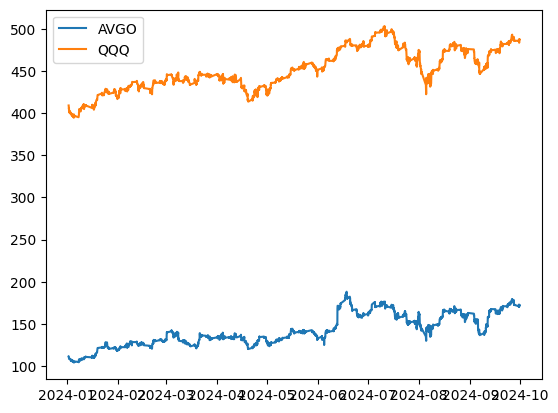

In [5]:
s1_name = 'AVGO'
s2_name = 'QQQ'
S1 = df[s1_name]
S2 = df[s2_name]

plt.plot(S1, label = s1_name)
plt.plot(S2, label = s2_name)
plt.legend()

In [6]:
train = int(len(df[s1_name]) * 1)
test = len(df[s1_name]) - train

S1_train = df[s1_name][:train]
S2_train = df[s2_name][:train]

aligned_data = pd.concat([S1_train, S2_train], axis=1).dropna()
log_S1 = np.log(aligned_data[s1_name])
log_S2 = np.log(aligned_data[s2_name])


log_S1_with_const = sm.add_constant(log_S1)
results = sm.OLS(log_S2, log_S1_with_const).fit()

print(results.summary())
print (results.params)

a, b = results.params

log_spread = log_S2 - b*(log_S1)

                            OLS Regression Results                            
Dep. Variable:                    QQQ   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 4.635e+04
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:21:26   Log-Likelihood:                 9002.9
No. Observations:                3129   AIC:                        -1.800e+04
Df Residuals:                    3127   BIC:                        -1.799e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1478      0.009    454.749      0.0

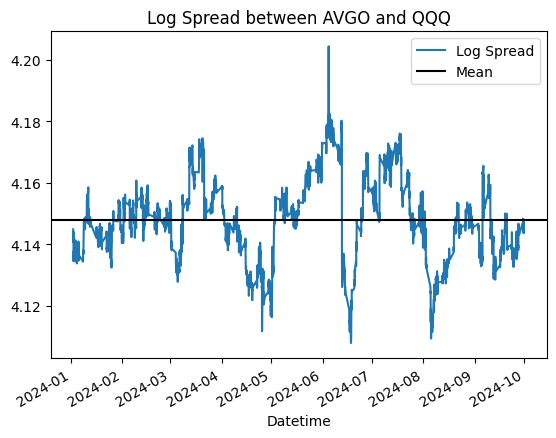

In [7]:
log_spread.plot()
plt.axhline(log_spread.mean(), color='black')
plt.legend(['Log Spread', 'Mean'])
plt.title(f'Log Spread between {s1_name} and {s2_name}')

plt.show()

**Using Moving Average to eliminate look-ahead bias**
- As the current mean takes into account of data from start to end, it falls prey to the look-ahead bias.
- As such, use a rolling window (moving average) to eliminate the bias.

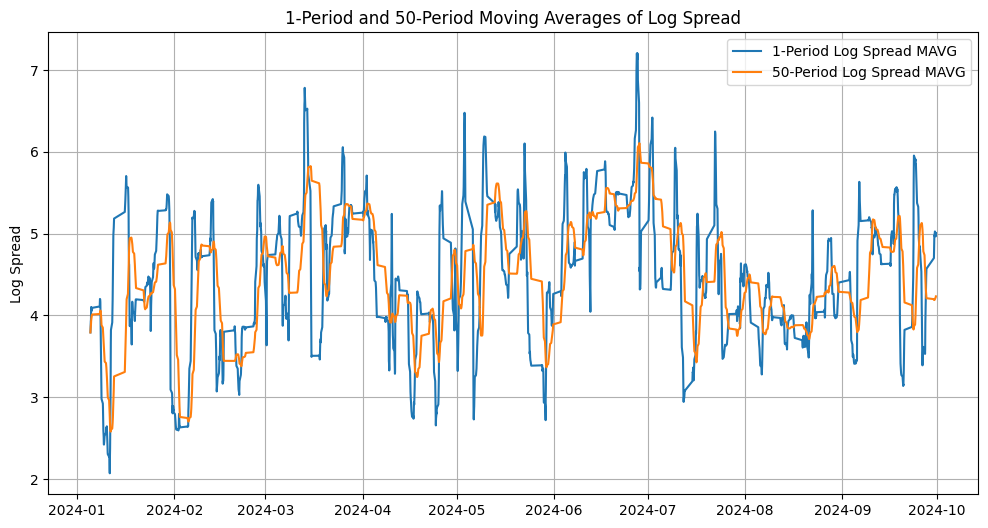

In [8]:
def calculate_beta(x, y):
    X_with_const = sm.add_constant(x)  # Add constant for intercept
    model = sm.OLS(y, X_with_const).fit()  # Fit the OLS model
    return model.params.iloc[1]  # Return the beta (slope) coefficient

def calculate_rolling_beta(S1, S2, window):
    rolling_betas = []
    for i in range(window, len(S1) + 1):
        X_window = S1.iloc[i-window:i]
        y_window = S2.iloc[i-window:i]
        beta = calculate_beta(X_window, y_window)
        rolling_betas.append(beta)

    return pd.Series(rolling_betas, index=S1.index[window-1:])

# Calculate rolling beta with a window size of 50
rolling_beta = calculate_rolling_beta(log_S1, log_S2, window=50)

# Calculate the spread (difference between S2 and beta-adjusted S1)
log_spread = log_S2[rolling_beta.index] - rolling_beta * log_S1[rolling_beta.index]
log_spread.name = 'Log Spread'

# Calculate moving averages
spread_mavg1 = log_spread.rolling(window=1, min_periods=1, center=False).mean()
spread_mavg1.name = 'Log Spread 1-Period MAVG'

spread_mavg50 = log_spread.rolling(window=50, min_periods=1, center=False).mean()
spread_mavg50.name = 'Log Spread 50-Period MAVG'
# Plot the spread moving averages
plt.figure(figsize=(12, 6))
plt.plot(spread_mavg1.index, spread_mavg1.values, label='1-Period Log Spread MAVG')
plt.plot(spread_mavg50.index, spread_mavg50.values, label='50-Period Log Spread MAVG')

plt.legend()
plt.ylabel('Log Spread')
plt.title('1-Period and 50-Period Moving Averages of Log Spread')
plt.grid()
plt.show()


Calculate z-scores to normalize signals

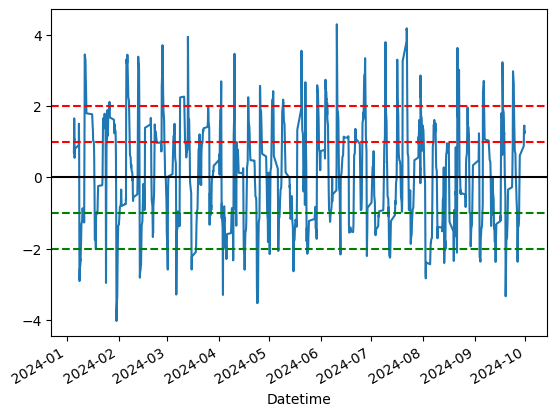

In [9]:
std_50 = log_spread.rolling(min_periods=1, window=50, center=False).std()
std_50.name = 'std 50p'

zscore_spread_50_1 = (spread_mavg1 - spread_mavg50)/std_50
zscore_spread_50_1.name = 'z-score'
zscore_spread_50_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')

plt.show()

## **Further Works**

With the computed z-scores, we can then subsequently determine the entry and exit points of our trades. As the previous notebook has already implemented the entry and exit algorithm, do refer to the previous notebook on the algorithm implementation.